In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'utils/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:yi ge
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Normalize images
X_train /= 255
X_test /= 255

X_train = np.reshape(X_train, (-1, 32 * 32 * 3))
X_test = np.reshape(X_test, (-1, 32 * 32 * 3))

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [3]:
subset_size = 128
train_loader =  [(T.from_numpy(X_train[i:i + subset_size]).float().to(device),
                  T.from_numpy(y_train[i:i + subset_size]).long().to(device))
                 for i in range(0, X_train.shape[0], subset_size)]

subset_size = 512
test_loader =  [(T.from_numpy(X_test[i:i + subset_size]).float().to(device),
                  T.from_numpy(y_test[i:i + subset_size]).long().to(device))
                 for i in range(0, X_test.shape[0], subset_size)]

len(train_loader), len(test_loader)

(391, 20)

In [4]:
train_loader[0][0].size()

torch.Size([128, 3072])

In [5]:
def evaluate(model, train_loader, test_loader, epoch, train_acc, test_acc, train_loss, test_loss):
    if epoch % 20 == 0:
        print('Epoch: {} '.format(epoch), end='   ')
        
    # calculate training accuracy
    ep_train_outputs = T.cat([net(data[0]) for data in train_loader], 0)
    train_l = criterion(ep_train_outputs.cpu(), T.from_numpy(y_train))
    ep_train_outputs = T.max(ep_train_outputs, 1)
    acc = np.sum(ep_train_outputs[1].cpu().numpy().flatten() == y_train) / 50000
    train_acc.append(acc)
    train_loss.append(train_l)
    del ep_train_outputs
    if epoch % 20 == 0:
        print('Train accuracy:', acc, end='   ')

    # calculate test accuracy
    ep_test_outputs = T.cat([net(data[0]) for data in test_loader], 0)
    test_l = criterion(ep_test_outputs.cpu(), T.from_numpy(y_test))
    ep_test_outputs = T.max(ep_test_outputs, 1)
    acc = np.sum(ep_test_outputs[1].cpu().numpy().flatten() == y_test) / 10000
    test_acc.append(acc)
    test_loss.append(test_l)
    del ep_test_outputs
    if epoch % 20 == 0:
        print('Test accuracy:', acc)
    
def plot_evaluation(train_acc, test_acc, train_loss, test_loss, model_name=''):

    plt.figure(figsize=(6, 10))
    plt.tight_layout()
    plt.subplot(211)
    plt.plot(train_acc, label='train')
    plt.plot(test_acc, label='test')
    plt.legend()
    plt.title('{} Training/Test Accuracy'.format(model_name))

    plt.subplot(212)
    plt.plot(train_loss, label='train')
    plt.plot(test_loss, label='test')
    plt.legend()
    plt.title('{} Training/Test Loss'.format(model_name))
    plt.show()

## Architectures

Now that you've been familiar with the dataset, we will now build 3 models, they are:

- a simple softmax-favor classification model.
- a two-layer neural network
- a deeper neural network

In [6]:
class SoftmaxRegression(nn.Module):
    def __init__(self):
        super(SoftmaxRegression, self).__init__()
        self.fc1 = nn.Linear(3072, 10)
        self.softmax = nn.Softmax()
    def forward(self, x):
        out = F.softmax(self.fc1(x))
        return out
    
net = SoftmaxRegression()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

train_acc = []
test_acc = []
train_loss = []
test_loss = []

s = time.time()
for epoch in range(128):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with T.no_grad():
        evaluate(net, train_loader, test_loader, epoch, train_acc, test_acc, train_loss, test_loss)
    
print('Finished training, time used:', )
del net
T.cuda.empty_cache()

/home/jiyang/.conda/envs/altaml/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


Epoch: 0    Train accuracy: 0.3052   Test accuracy: 0.3033
Epoch: 20    Train accuracy: 0.41406   Test accuracy: 0.3961
Epoch: 40    Train accuracy: 0.4267   Test accuracy: 0.4033
Epoch: 60    Train accuracy: 0.43218   Test accuracy: 0.4075
Epoch: 80    Train accuracy: 0.43602   Test accuracy: 0.4081
Epoch: 100    Train accuracy: 0.43778   Test accuracy: 0.4077
Epoch: 120    Train accuracy: 0.43904   Test accuracy: 0.4085
Finished training, time used:


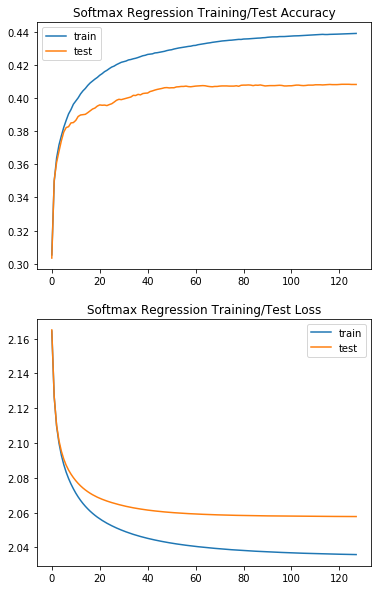

In [7]:
plot_evaluation(train_acc, test_acc, train_loss, test_loss, model_name='Softmax Regression')

In [8]:
class TwoLayerNeuralNetwork(nn.Module):
    def __init__(self):
        super(TwoLayerNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(out))
        return out
    
net = TwoLayerNeuralNetwork()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

train_acc = []
test_acc = []
train_loss = []
test_loss = []

for epoch in range(200):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with T.no_grad():
        evaluate(net, train_loader, test_loader, epoch, train_acc, test_acc, train_loss, test_loss)
    
print('Finished Training')
del net
T.cuda.empty_cache()

/home/jiyang/.conda/envs/altaml/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Epoch: 0    Train accuracy: 0.28238   Test accuracy: 0.2832
Epoch: 20    Train accuracy: 0.4547   Test accuracy: 0.4334
Epoch: 40    Train accuracy: 0.49324   Test accuracy: 0.4561
Epoch: 60    Train accuracy: 0.52446   Test accuracy: 0.4722
Epoch: 80    Train accuracy: 0.51964   Test accuracy: 0.4653
Epoch: 100    Train accuracy: 0.56118   Test accuracy: 0.4914
Epoch: 120    Train accuracy: 0.55638   Test accuracy: 0.4838
Epoch: 140    Train accuracy: 0.57092   Test accuracy: 0.4938
Epoch: 160    Train accuracy: 0.5959   Test accuracy: 0.5058
Epoch: 180    Train accuracy: 0.59442   Test accuracy: 0.5049
Finished Training


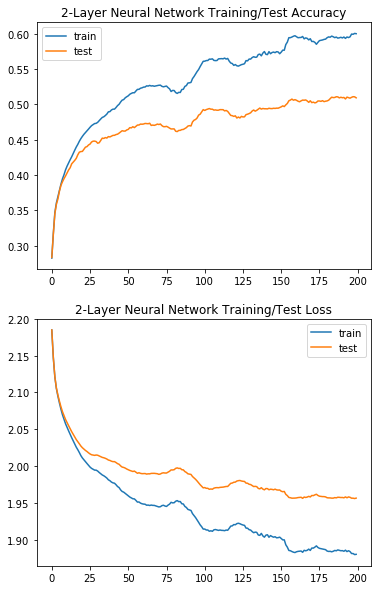

In [9]:
plot_evaluation(train_acc, test_acc, train_loss, test_loss, model_name='2-Layer Neural Network')

In [10]:
class TwoLayerNeuralNetwork(nn.Module):
    def __init__(self):
        super(TwoLayerNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(out))
        return out
    
net = TwoLayerNeuralNetwork()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_acc = []
test_acc = []
train_loss = []
test_loss = []

for epoch in range(200):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    with T.no_grad():
        evaluate(net, train_loader, test_loader, epoch, train_acc, test_acc, train_loss, test_loss)
    
print('Finished Training')
del net
T.cuda.empty_cache()

/home/jiyang/.conda/envs/altaml/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Epoch: 0    Train accuracy: 0.29412   Test accuracy: 0.2917
Epoch: 20    Train accuracy: 0.48372   Test accuracy: 0.4528
Epoch: 40    Train accuracy: 0.53682   Test accuracy: 0.4815
Epoch: 60    Train accuracy: 0.55504   Test accuracy: 0.4791
Epoch: 80    Train accuracy: 0.58552   Test accuracy: 0.4888
Epoch: 100    Train accuracy: 0.6021   Test accuracy: 0.4986
Epoch: 120    Train accuracy: 0.61156   Test accuracy: 0.4922
Epoch: 140    Train accuracy: 0.63092   Test accuracy: 0.5001
Epoch: 160    Train accuracy: 0.6299   Test accuracy: 0.4987
Epoch: 180    Train accuracy: 0.63154   Test accuracy: 0.4963
Finished Training


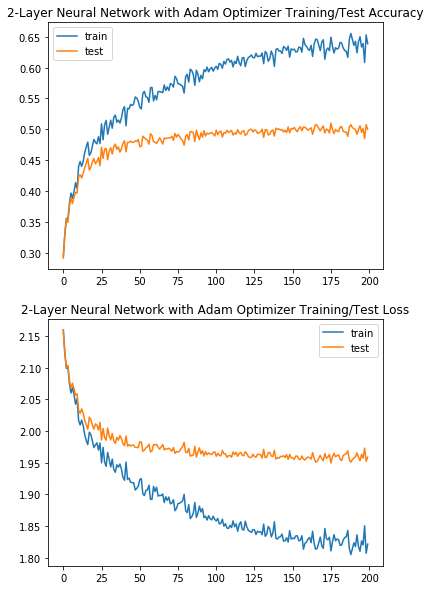

In [11]:
plot_evaluation(train_acc, test_acc, train_loss, test_loss, model_name='2-Layer Neural Network with Adam Optimizer')